In [1]:
import tensorflow as tf
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

blocks to build the generator

In [3]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])


In [4]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

Generator model

In [5]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


Descriminator block that will be used to construct the discriminator

In [6]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


Descriminartor

In [7]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

VGG19 

In [8]:
from tensorflow.keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

Combined model


In [9]:
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [10]:
n=5000
lr_list = os.listdir("lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

Sanity check, view few mages

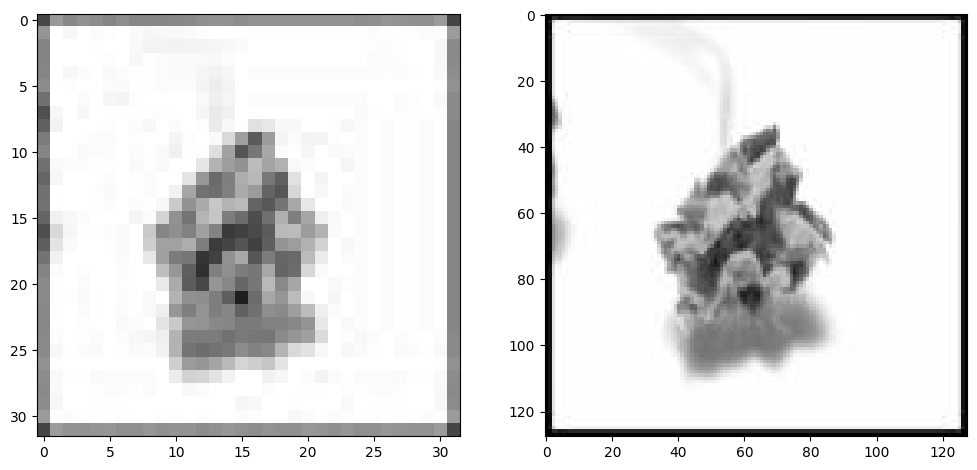

In [11]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

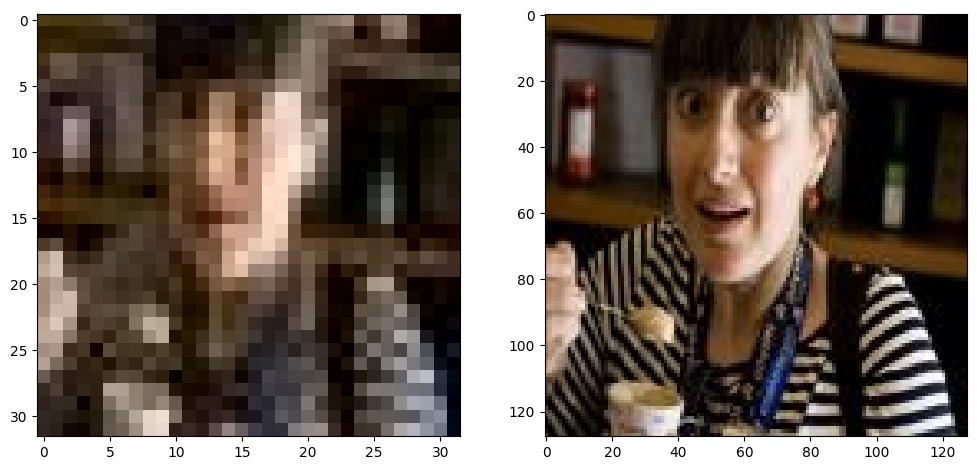

In [12]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

Scale values

In [13]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 32, 32, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   36928       p_re_lu[0][0]                    
______________________________________________________________________________________________

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 128)       7385

In [14]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            38249281    model[0][0]                      
____________________________________________________________________________________________

In [15]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128, 128, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 1)            38249281    model[0][0]                      
____________________________________________________________________________________________

In [43]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])
    
    
epochs = 15

In [44]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Enumerate training over epochs

In [45]:
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 15 == 0: 
        #Save the generator after every n epochs 
        generator.save("gen_e_"+ str(e+1) +".h5")

100%|██████████| 3350/3350 [11:20<00:00,  4.92it/s]


epoch: 1 g_loss: 43.03008778693071 d_loss: [0.01486518 0.99865672]


100%|██████████| 3350/3350 [11:06<00:00,  5.02it/s]


epoch: 2 g_loss: 41.922558670897985 d_loss: [0.04207596 0.99791045]


100%|██████████| 3350/3350 [10:52<00:00,  5.13it/s]


epoch: 3 g_loss: 45.51129873859349 d_loss: [0.05370661 0.99776119]


100%|██████████| 3350/3350 [10:48<00:00,  5.17it/s]


epoch: 4 g_loss: 40.280411904605465 d_loss: [4.69132688e-06 1.00000000e+00]


100%|██████████| 3350/3350 [10:50<00:00,  5.15it/s]


epoch: 5 g_loss: 42.51859157896754 d_loss: [1.42359387e-08 1.00000000e+00]


100%|██████████| 3350/3350 [10:53<00:00,  5.13it/s]


epoch: 6 g_loss: 38.43425026594703 d_loss: [0.05423972 0.99865672]


100%|██████████| 3350/3350 [10:48<00:00,  5.16it/s]


epoch: 7 g_loss: 37.29411166297856 d_loss: [0.05472143 0.99850746]


100%|██████████| 3350/3350 [10:49<00:00,  5.16it/s]


epoch: 8 g_loss: 43.87344052492683 d_loss: [8.93882837e-07 1.00000000e+00]


100%|██████████| 3350/3350 [10:52<00:00,  5.14it/s]


epoch: 9 g_loss: 37.19995931625366 d_loss: [2.91771276e-08 1.00000000e+00]


100%|██████████| 3350/3350 [10:47<00:00,  5.18it/s]


epoch: 10 g_loss: 36.483061020409885 d_loss: [1.9486784e-09 1.0000000e+00]


100%|██████████| 3350/3350 [10:48<00:00,  5.17it/s]


epoch: 11 g_loss: 34.99321289026915 d_loss: [1.22307107e-10 1.00000000e+00]


100%|██████████| 3350/3350 [10:48<00:00,  5.16it/s]


epoch: 12 g_loss: 34.386478603348806 d_loss: [1.0987327e-11 1.0000000e+00]


100%|██████████| 3350/3350 [10:47<00:00,  5.17it/s]


epoch: 13 g_loss: 33.67748277116178 d_loss: [2.72789881e-12 1.00000000e+00]


100%|██████████| 3350/3350 [10:46<00:00,  5.18it/s]


epoch: 14 g_loss: 34.839019972530764 d_loss: [1.773544e-12 1.000000e+00]


100%|██████████| 3350/3350 [10:47<00:00,  5.17it/s]

epoch: 15 g_loss: 32.0186360431785 d_loss: [1.41748575e-12 1.00000000e+00]


In [25]:
    if (e+1) % 15 == 0: 
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

C:\Users\Vedu\anaconda3\envs\firstenv\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


1/1 [==============================] - 1s 1s/step


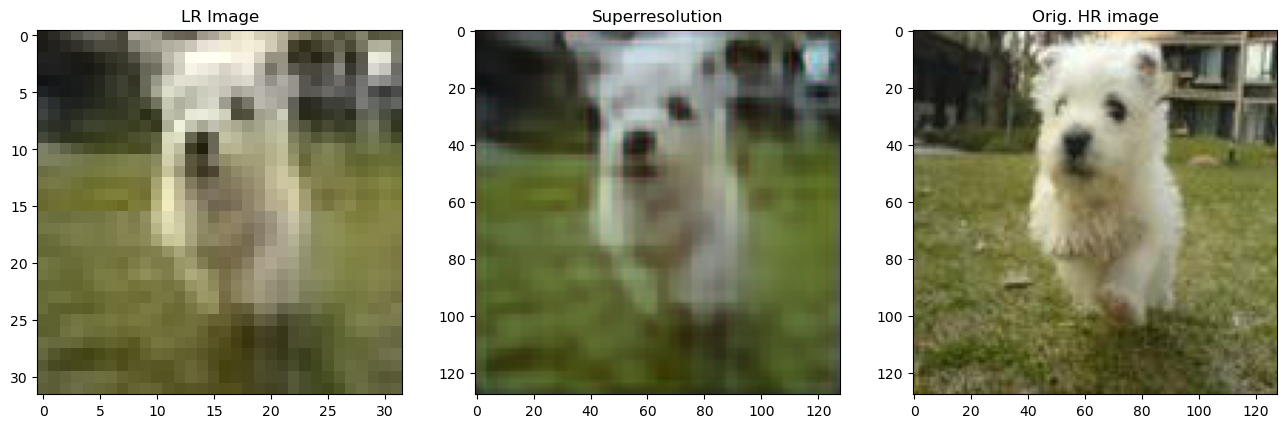

In [15]:
import os
from keras.models import load_model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the generator model
generator = load_model('gen_e_5.h5', compile=False)

# Path to the directory containing LR and HR images
lr_folder = "lr_images"
hr_folder = "hr_images"

# List all files in the directories
lr_files = os.listdir(lr_folder)
hr_files = os.listdir(hr_folder)

# Ensure that the number of LR and HR images is the same
assert len(lr_files) == len(hr_files), "Number of LR and HR images must be the same"

# Randomly select an index for LR and HR data
ix = np.random.choice(len(lr_files))

# Construct the full paths to the LR and HR images
lr_path = os.path.join(lr_folder, lr_files[ix])
hr_path = os.path.join(hr_folder, hr_files[ix])

# Load the LR and HR images using Pillow
src_image = Image.open(lr_path)
tar_image = Image.open(hr_path)

# Generate high-resolution image from LR input
gen_image = generator.predict(np.array(src_image).reshape(1, src_image.size[1], src_image.size[0], 3))

# Plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(131)
plt.title('LR Image')
plt.imshow(src_image)
plt.subplot(132)
plt.title('Superresolution')
plt.imshow(gen_image[0].astype(np.uint8))  # Convert to uint8 for plotting
plt.subplot(133)
plt.title('Orig. HR image')
plt.imshow(tar_image)
plt.show()


In [18]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error


# Flatten the arrays
tar_image_flat = tar_image.flatten()
gen_image_flat = gen_image.flatten()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(tar_image_flat, gen_image_flat)

print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 361.3999938964844
